### Initialization cell: run once on notebook start up

In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import pickle

# Find the index from xvals of the value which is closest to xval.  If more than one exact match, returns the lowest index
# xvals should be spaced less than 66e6 apart
def findindex(xvals,xval): 
    minima = 66e6
    for i,elem in enumerate(xvals):
        # Update minimum difference from xval and index of the minimum difference
        if abs(xval-elem) < minima: 
            minima = abs(xval-elem) 
            index = i
    return index

# Find the x value corresponding to the max y value from the sets xvals, yvals in the range from xmin to xmax
def findmax(xvals,yvals,xmin,xmax): 
    xminindex = -666
    xmaxindex = -666
    # Find the indexes of the limits using findindex function
    xminindex = findindex(xvals,xmin)
    xmaxindex = findindex(xvals,xmax)
    # Find the max y value and the x value which is at the same index
    maxy = max(yvals[xminindex:xmaxindex])
    maxx = xvals[np.where(yvals==maxy)[0][0]]
    #maxx = 0
    return maxx,maxy #return peak as x,y coordinate tuple

def histtoplot(histdata,bins): #data to be binned, number of bins
    graph = []
    newbins=[]
    count,bincount,bars=plt.hist(histdata,bins)
    
    for i in range(len(bincount)-1):
        newbins.append(bincount[i]/2+bincount[i+1]/2)
    graph.append(newbins)
    graph.append(count)
    graph.append(len(count))
    graph.append(int(sum(count)))
    return graph #a list of 4 elements: a list of x values, a list of y values, the number of data points, & the integral of the distribution

= bincenters[-1] - bincenters[0] #total integration period
N = len(bincenters) #number of points
hires = 2 #high resolution at low frequencies, set to at least 2;
#gives a factor of $hires finer frequency sampling, but with a factor of $hires smaller
hires_start = 0.03 #start high resolution requency scan at frequency=hiresoff/T/hires -- set to 0
hiresoff=int(np.floor(hires_start*T*hires))
SipmPixelCalibration about:srcdoc### User Inputs

<function matplotlib.pyplot.show(close=None, block=None)>

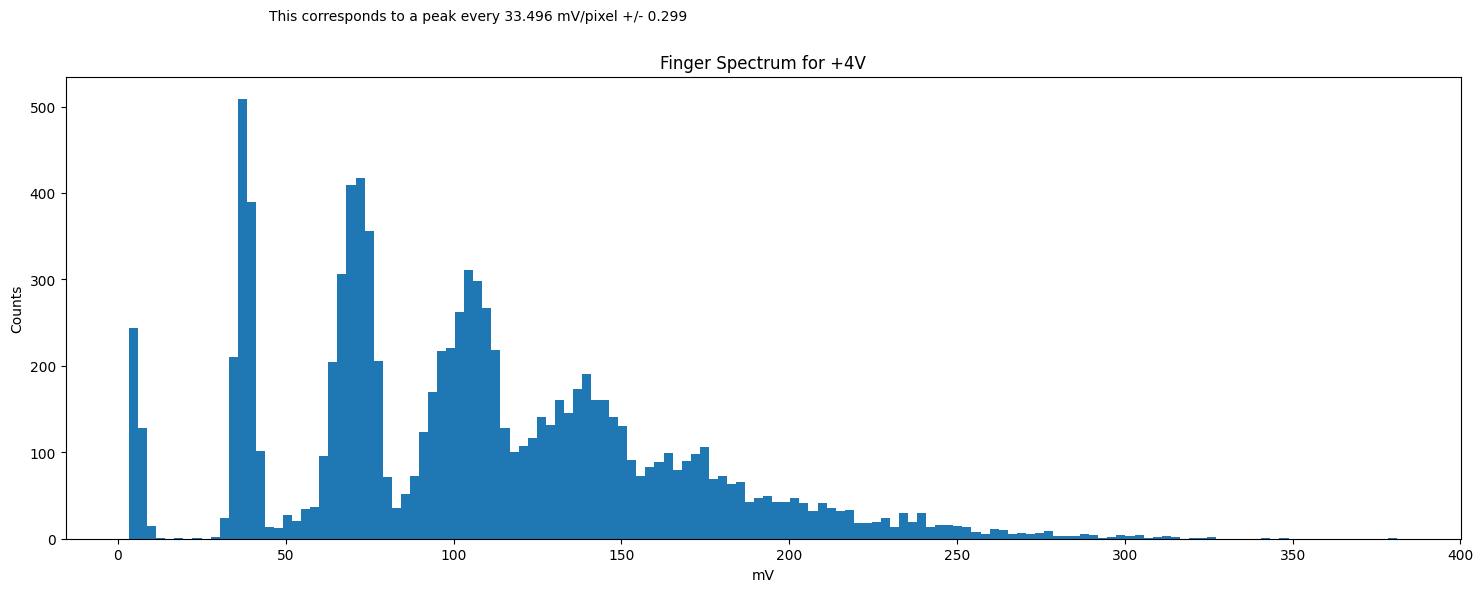

In [17]:
#    Load a dataset of peak-to-peak values which you wish to bin into a finger spectrum
with open('FingerSpectrum4V.pkl', 'rb') as f:
    dataframe = pickle.load(f)
p2ps = dataframe.eval('ch2_P2P_smooth')


hires = 10 #high resolution at low frequencies, set to at least 2;
          #gives a factor of $hires finer frequency sampling, but with a factor of $hires smaller frequency window
    
hiresoff = 80 #start high resolution requency scan at frequency hiresoff/T/hires -- set to 0 for standard lowpass filter

counts,binedges,bars=plt.hist(p2ps,140)
#plt.xlim(4,15)
#plt.ylim(0,500)
bincenters = binedges[:-1]/2+binedges[1:]/2

plt.title("Finger Spectrum for +4V")
plt.xlabel("mV")
plt.ylabel("Counts")
#plt.xticks(np.arange(200, step=5))
plt.text(45,600,"This corresponds to a peak every 33.496 mV/pixel +/- 0.299")
#plt.xlim(0,200)
plt.show

In [14]:
T = bincenters[-1] - bincenters[0] #total integration period
N = len(bincenters) #number of points
FFTs = np.zeros([3,N//2]) #Fourier frequencies, amplitudes, and phases
FFTshr = np.zeros([3,N//2]) #high res

# The DFT is always symmetric about its midpoint.
# Frequencies above the midpoint are below the Nyquist criterion and does not represent real frequencies.
for f in range(0,N//2): #iterate over frequencies
    A = 0
    Ahr = 0
    for d in range(N): #iterate over data points
        A += counts[d] * np.exp(-1j*2*np.pi*d*f/N) #integrate at frequencies f/N, A = a +ib for the fourier expansion f(t) = a*cos(wt)+bsin(wt)
        Ahr += counts[d] * np.exp(-1j*2*np.pi*d*(f+hiresoff)/N/hires)
    
    FFTs[0][f] = f/T #frequency
    FFTs[1][f] = la.norm(A)/N*2 #amplitude, factor of 2 to account for symmetry of DFT
    FFTs[2][f] = np.arctan2(np.imag(A),np.real(A)) #phase
    
    FFTshr[0][f] = (f+hiresoff)/T/hires #hires frequency
    FFTshr[1][f] = la.norm(Ahr)/N/hires*2 #hires amplitude
    FFTshr[2][f] = np.arctan2(np.imag(Ahr),np.real(Ahr)) #hires phase

#Inverse Fourier transform
invFT = np.zeros(N,complex)
invFThr = np.zeros(N,complex)

for d in range(N): #iterate over data points
    for f in range(N//2): #iterate over frequencies
        invFT[d] += FFTs[1][f] * np.exp(2j*np.pi*d/N*f+1j*FFTs[2][f])
        invFThr[d] += FFTshr[1][f] * np.exp(2j*np.pi*d/N*(f+hiresoff)/hires+1j*FFTshr[2][f])
#take real part and add the DC offset back
ReinvFT = np.real(invFT) + counts[0] - np.real(invFT[0])
ReinvFThr = np.real(invFThr) + counts[0] - np.real(invFThr[0])

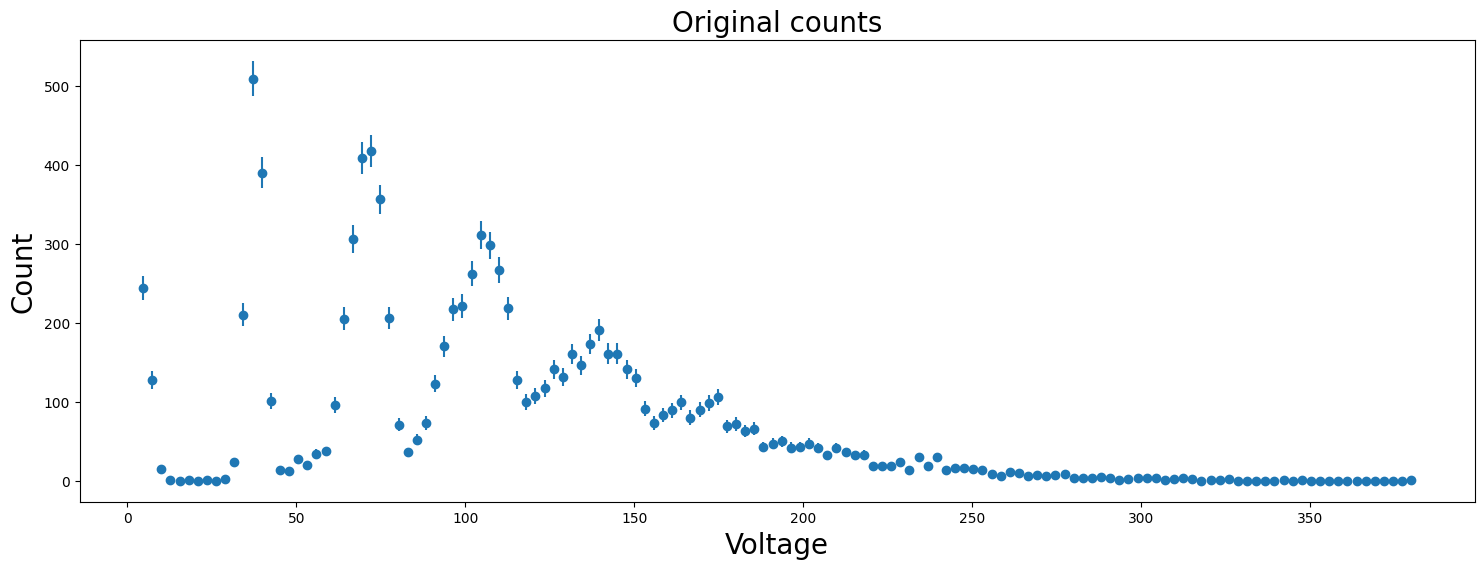

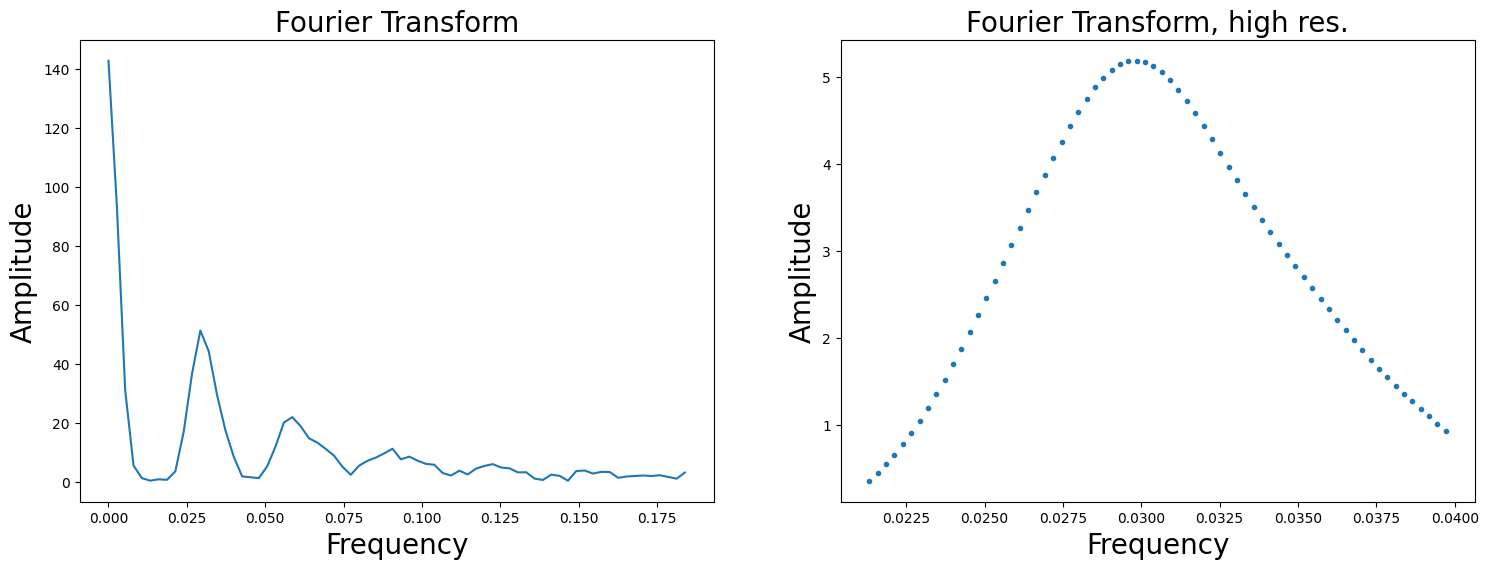

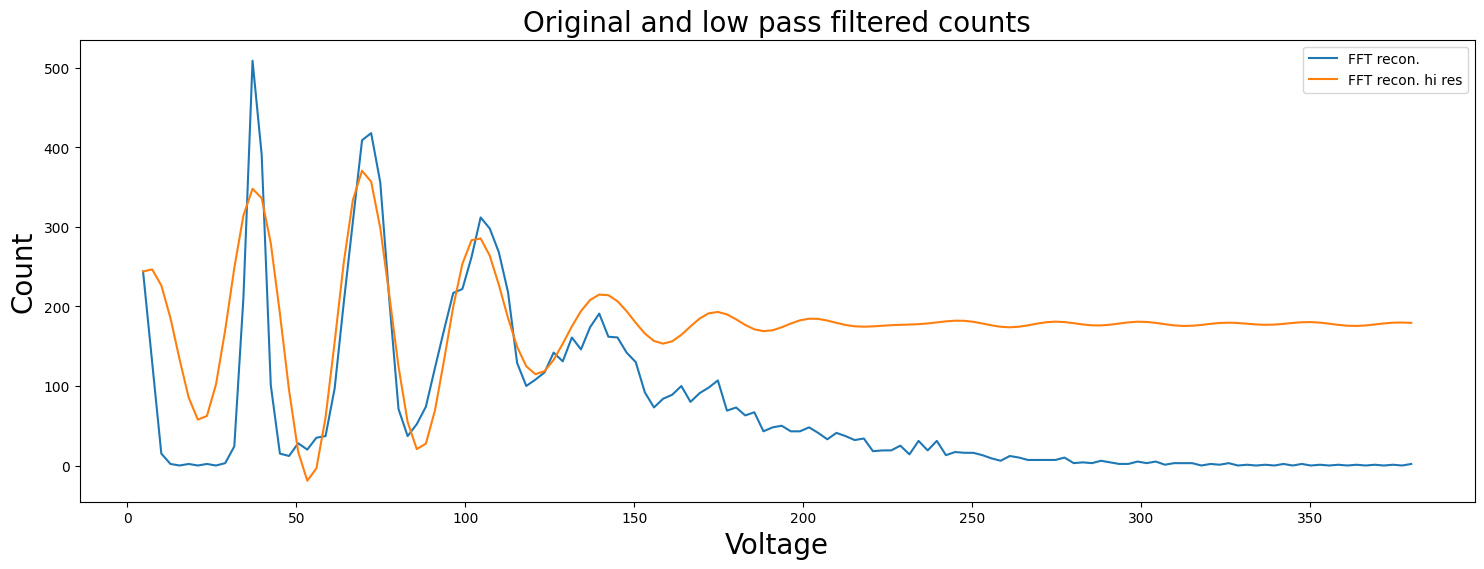

In [15]:
#make plots
plt.rcParams["figure.figsize"] = (18,6)
plt.errorbar(bincenters,y=counts,yerr=np.sqrt(counts),fmt='o')

plt.title("Original counts", size=20)
plt.xlabel("Voltage", size=20)
plt.ylabel("Count", size=20)
plt.show()

fig,ax = plt.subplots(1,2,figsize=(18,6))
ax[0].plot(FFTs[0],FFTs[1],"-")
ax[0].set_title("Fourier Transform", size=20)
ax[0].set_xlabel("Frequency", size=20)
ax[0].set_ylabel("Amplitude", size=20)

ax[1].plot(FFTshr[0],FFTshr[1],".")
ax[1].set_title("Fourier Transform, high res.", size=20)
ax[1].set_xlabel("Frequency", size=20)
ax[1].set_ylabel("Amplitude", size=20)
plt.show()

plt.plot(bincenters,ReinvFT,label="FFT recon.")
plt.plot(bincenters,ReinvFThr,label="FFT recon. hi res")
plt.legend()
plt.title("Original and low pass filtered counts", size=20)
plt.xlabel("Voltage", size=20)
plt.ylabel("Count", size=20)
plt.savefig('fingerspectrum42_25V')
plt.show()

In [16]:
#Find the maxima in the high resolution frequency scan
xmax,ymax=findmax(FFTshr[0],FFTshr[1],0.025,0.035)  #note: last two inputs to this function define the frequency bounds within which it searches for the maxima
uncertainty = (FFTshr[0][1]-FFTshr[0][0])/xmax

print(f"maxima found in the given range at x={xmax:.2f}, y={ymax:.2f}")
print(f'This corresponds to a peak every {1/xmax:.3f} mV/pixel +/- {uncertainty*1/xmax:.3f}')
#print(1/(max_x+0.00011))

maxima found in the given range at x=0.03, y=5.18
This corresponds to a peak every 33.496 mV/pixel +/- 0.299


In [ ]:
counts,binedges,bars=plt.hist(dataframe.eval('ch2_time_fit - ch1_time_fit'),140,range = (20,40))

In [ ]:
FFTshr[1]